In [1]:
import os
import pickle
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# Define the directory containing the data files
data_directory = '../data/data/speech/lines'

In [3]:
# Function to load data from a single .pkl file
def load_data_from_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data['strokes']

In [4]:
def abs_to_rel(points, index, first_point_zero):
    if not points:
        return []
    
    print(points)
    offsets = []
    first_point = points[0]
    prev_absolute = first_point[index]
    
    if not first_point_zero:
        offsets = [points[0]]
        points = points[1:]
    
    for p in points:
        new_absolute = p[index]
        p[index] = p[index] - prev_absolute
        offsets.append(p)
        prev_absolute = new_absolute
        
    return offsets

In [5]:
# Load all data from files in the directory
all_data = []
for file_name in os.listdir(data_directory):
    if file_name not in ['.DS_Store']:
        file_path = os.path.join(data_directory, file_name)
        line_data = load_data_from_file(file_path)
        all_data.append(line_data)

In [6]:
# Flatten the data preserving the line structure and creating the end_of_stroke_boolean
# Input points are (x, y, pen_pressure)
# Output points are (x, y, end_of_stroke_boolean, pen_pressure)
sequences = []
for line in all_data:
    sequence = []
    for stroke in line:
        # Add the end_of_stroke_boolean
        for i, point in enumerate(stroke):
            if i == len(stroke) - 1:
                sequence.append([point[0], point[1], 1, point[2]])
            else:
                sequence.append([point[0], point[1], 0, point[2]])

    # Change x, y, and pen pressure to relative coordinates
    sequence = abs_to_rel(sequence, 0, True)
    sequence = abs_to_rel(sequence, 1, True)
    sequence = abs_to_rel(sequence, 3, False)

    sequences.append(sequence)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



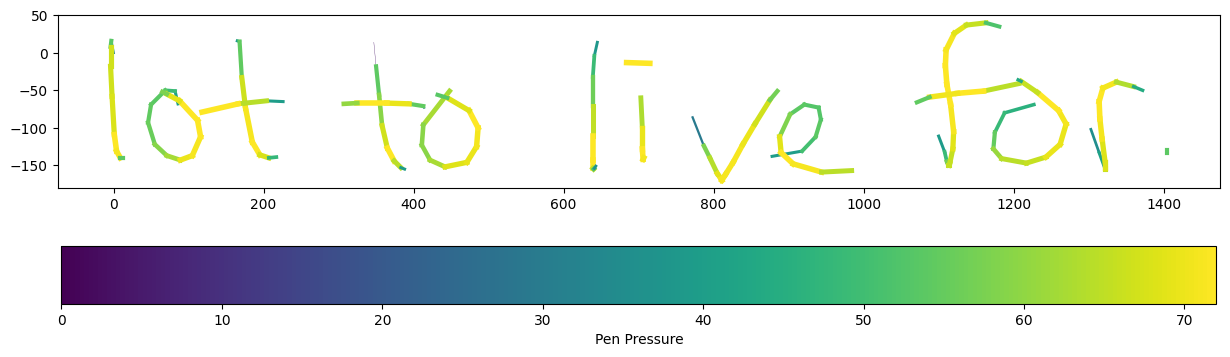

In [7]:
def plot_line_from_strokes_thick(sequence):
    
    # Turn sequence into strokes by turning the relative coordinates back into absolute coordinates
    points = [sequence[0]]
    for i in range(1, len(sequence)):
        x, y, eos, p = sequence[i]
        prev_x, prev_y, _, prev_p = points[-1]
        points.append([x + prev_x, y + prev_y, eos, p + prev_p])
        
        
    strokes = []
    stroke = []
    for point in points:
        if point[2] == 1:
            stroke.append(point)
            strokes.append(stroke)
            stroke = []
        else:
            stroke.append(point)
            
    
    # Set the size of the plot
    plt.figure(figsize=(15, 5))
    
    for stroke in strokes:
        x = [point[0] for point in stroke]
        y = [point[1] for point in stroke]
        pen_pressure = [point[3] for point in stroke]

        # Normalize the pen pressure to be between 0 and 4
        pen_pressure_norm = [(pressure - min(pen_pressure)) / (max(pen_pressure) - min(pen_pressure)) * 4 for pressure
                             in pen_pressure]

        # Invert the y axis
        y = [-i for i in y]

        # Plot each segment with the corresponding pen pressure
        for i in range(len(x) - 1):
            color_value = (pen_pressure[i] - min(pen_pressure)) / (max(pen_pressure) - min(pen_pressure))
            plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], linewidth=pen_pressure_norm[i],
                     color=plt.cm.viridis(color_value))

    # Stretch the plot to match the aspect ratio of the text
    plt.gca().set_aspect('equal', adjustable='box')

    # Add a colorbar for reference
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(p[3] for stroke in strokes for p in stroke),
                                                                  vmax=max(p[3] for stroke in strokes for p in stroke)))
    plt.colorbar(sm, ax=plt.gca(), label='Pen Pressure', orientation='horizontal')

    return plt.show()


plot_line_from_strokes_thick(sequences[3])

In [8]:
# Convert to numpy array
sequences = [np.array(seq) for seq in sequences]

In [9]:
# Ensure that all sequences are of the same length by padding them
max_length = max(len(seq) for seq in sequences)
X = []
y = []
for seq in sequences:
    if len(seq) < max_length:
        padding = np.zeros((max_length - len(seq), 4))
        seq = np.vstack([seq, padding])
    X.append(seq[:, :3])  # (x_coordinate, y_coordinate, end_of_stroke_boolean)
    y.append(seq[:, 3])  # pen_pressure
X = np.array(X)
y = np.array(y)

In [10]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [12]:
# Save the datasets
torch.save((X_train, y_train), 'train_data.pt')
torch.save((X_val, y_val), 'val_data.pt')